In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
import pandas as pd
import numpy as np
from spatialsurf.utils.data_pp import spatial_pp
from spatialsurf.utils.deconvolution import deconvolution_multi_ctn
from spatialsurf.utils.get_data_from_h5 import get_data_from_h5
from spatialsurf.utils.cell_type_visualization import visualize_lineplot, celltype_visualization_visium
from spatialsurf.models.wae import WAE
import torch
import torch.nn.functional as F

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [2]:
data_dir = 'Example_data/colorectal_liver_metastasis_data/raw_data/'
save_dir = 'Example_data/colorectal_liver_metastasis_data/pp_data/'
expr_path = data_dir + 'expr.feather'
pos_path = data_dir + 'pos.csv'
barcodes_path = data_dir + 'barcodes.csv'
device_id = 0
num_workers = 0  # Windows: Recommended to set 'num_workers=0'; Linux/macOS: Recommended to set 'num_workers>0' (e.g., num_workers=1)

# 1. Read data

In [3]:
df_expr = pd.read_feather(expr_path)
df_pos = pd.read_csv(pos_path)
barcode = pd.read_csv(barcodes_path).iloc[:, 0].to_list()

# 2. Data preprocessing

### Function input
&nbsp;&nbsp;&nbsp;&nbsp;**df_expr**: (dataframe), column names: gene names, shape: (n_spots, n_genes). The gene expression of ST data. 
    
&nbsp;&nbsp;&nbsp;&nbsp;**df_pos**: (dataframe), column names: ‘x’, ‘y’, shape: (n_spots, 2). The position data of ST data.
    
&nbsp;&nbsp;&nbsp;&nbsp;**barcodes**: (list), len: n_spots. The barcodes of ST data.  

&nbsp;&nbsp;&nbsp;&nbsp;**save_dir**: (str). The directory to save the preprocessed data.
### Function output

&nbsp;&nbsp;&nbsp;&nbsp;**df_pp_data**: (dataframe), shape: (n_spots, (3 + n_genes)). The preprocessed ST data. The first three columns represent spot_id, x-coordinate, and y-coordinate, respectively. The remaining columns correspond to different genes.

In [4]:
os.makedirs(save_dir, exist_ok=True)
df_pp_data = spatial_pp(df_expr=df_expr.copy(), df_pos=df_pos.copy(), barcodes=barcode.copy(), save_dir=save_dir)

Data preprocessing begin...
Spots with no more than 100 gene counts are filtered out.
Genes present in all the spots are filtered out.
Genes detected in fewer than 5% of spots are filtered out.
Gene filtering begin...
1073 overdispersed genes remaining.
select the top 1000  most overdispersed genes by default.

Data preprocessing end.


# 3. Deconvolution
 (To save time, here we just set epoch=2 to show the deconvolution process. To get better deconvolution results, it is recommended to set epoch=500.) 

### Function input
&nbsp;&nbsp;&nbsp;&nbsp;**df_data**: (dataframe), shape: (n_spots, (3 + n_genes)). The preprocessed ST data. The first three columns represent spot_id, x-coordinate, and y-coordinate, respectively. The remaining columns correspond to different genes.

&nbsp;&nbsp;&nbsp;&nbsp;**cell_type_num**: (list). The cell type number.

&nbsp;&nbsp;&nbsp;&nbsp;**spatial_model**: (str, 'square', 'hexagon', or 'others'). The parameter is dependent on the spatial mode of spots.

&nbsp;&nbsp;&nbsp;&nbsp;**save_dir_name**: (str). The name of the folders where to save the deconvolution results.

&nbsp;&nbsp;&nbsp;&nbsp;**device_id**: (int). The id of the gpu you want to use.

&nbsp;&nbsp;&nbsp;&nbsp;**num_epoch**: (int, default=500). The number of epochs to train the model.

&nbsp;&nbsp;&nbsp;&nbsp;**num_workers**: (int, default=0). Number of worker processes for data loading.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Windows: Recommended to set 'num_workers=0'  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Linux/macOS: Recommended to set 'num_workers>0' (e.g., num_workers=1)  
### Function output

&nbsp;&nbsp;&nbsp;&nbsp;**df_deconvolution_data**: (dataframe), shape: (cell_type_number, 3). The value of representtaion discrepency and rare cell type number in deconvolution using different cell type number.

In [5]:
df_deconvolution_data, dataloader = deconvolution_multi_ctn(df_data=df_pp_data.copy(), cell_type_num=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], spatial_mode='hexagon', save_dir_name='colorectal_liver_metastasis_data', device_id=device_id, num_epoch=2, num_workers=num_workers)


Data organization...
Total_spot_num:3495
Data organization completed.
begin time:2025-07-23_23-17-11

Cell type number = 2, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 3, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 4, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 5, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 6, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 7, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 8, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 9, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 10, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 11, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 12, be

In [6]:
# Here we use the deconvolution results of epoch=500 for further exploration.
results_dir = 'results_save/colorectal_liver_metastasis_data/'
df_deconvolution_data = pd.read_csv(results_dir + '/colorectal_liver_metastasis_data.csv')

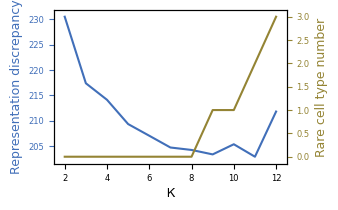

In [7]:
# Plot cell type number K versus perplexity and rare cell type number
cell_type_num = df_deconvolution_data.iloc[:, 0]
ppl = df_deconvolution_data.iloc[:, 2]
rare_cell_type_num = df_deconvolution_data.iloc[:, 1]
visualize_lineplot(cell_type_num, ppl, rare_cell_type_num)

In [8]:
# Choose a suitable cell_type_num for further visualization (The optimal cell type number K is determined at the point where reaches the lowest perplexity while minimizing the rare cell type number ideally. It is reconmmended to choose the cell type number with a low perplexity but not very high rare cell type number (For example, less than 3. If you want to explore more cell types, a higher rare cell type number is acceptable). Moreover, the user can choose the optimal K with the help their biology knowledge.)
cell_type_num = 11
if device_id != None:
    device = torch.device('cuda:{}'.format(device_id))
else:
    device = torch.device('cpu')
pkl_data = torch.load(results_dir + f'/model_save/cell_type_num_{cell_type_num}/last.pkl', map_location=device)
spatial_fea_num = df_pp_data.shape[1] - 3
model = WAE(encode_dims=[spatial_fea_num, 50, 30, cell_type_num], decode_dims=[cell_type_num, 50, spatial_fea_num], dropout=0.5, device=device)
model.load_state_dict(pkl_data)

model.to(device)
model.eval()
theta_all = torch.zeros([1, cell_type_num])
for iter, data in enumerate(dataloader):
    bows = data.to(device)
    _, theta_q, _ = model(bows)
    theta_all = torch.cat([theta_all, theta_q.detach().cpu()], dim=0)
theta_all = theta_all[1:, :]
decoder_w = model.state_dict()['decoder.0.weight'].T.detach().cpu()
beta = F.softmax(decoder_w, dim=1)

df_pred_raw = pd.DataFrame(theta_all.squeeze())
df_beta_raw = pd.DataFrame(beta, columns=df_pp_data.columns[3:])
df_pos_ = df_pp_data.iloc[:, 1:3]

In [9]:
# Change the order of deconvolved cell types for better visualization.
df_pred_ = pd.DataFrame(np.zeros([df_pred_raw.shape[0], df_pred_raw.shape[1]]), columns=df_pred_raw.columns)
df_beta_ = pd.DataFrame(np.zeros([df_beta_raw.shape[0], df_beta_raw.shape[1]]), columns=df_beta_raw.columns)
mapping_index = [7, 0, 3, 9, 4, 5, 1, 2, 10, 6, 8]
for i in mapping_index:
    df_pred_.iloc[:, mapping_index[i]] = df_pred_raw.iloc[:, i]
for i in mapping_index:
    df_beta_.iloc[mapping_index[i], :] = df_beta_raw.iloc[i, :]

D:\Temp\ipykernel_21656\2496545252.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_pred_.iloc[:, mapping_index[i]] = df_pred_raw.iloc[:, i]


# 4. Visualization of deconvolved cell type distribution

### Function input

&nbsp;&nbsp;&nbsp;&nbsp;**pred_p**: (dataframe), shape: (spot, cell_type_num). The deconvolved cell type proportions in each spot. 

&nbsp;&nbsp;&nbsp;&nbsp;**pos_all**: (dataframe), shape: (spot, 2). The position information of each spot. 

&nbsp;&nbsp;&nbsp;&nbsp;**col_num**: (int). The number of plot columns.

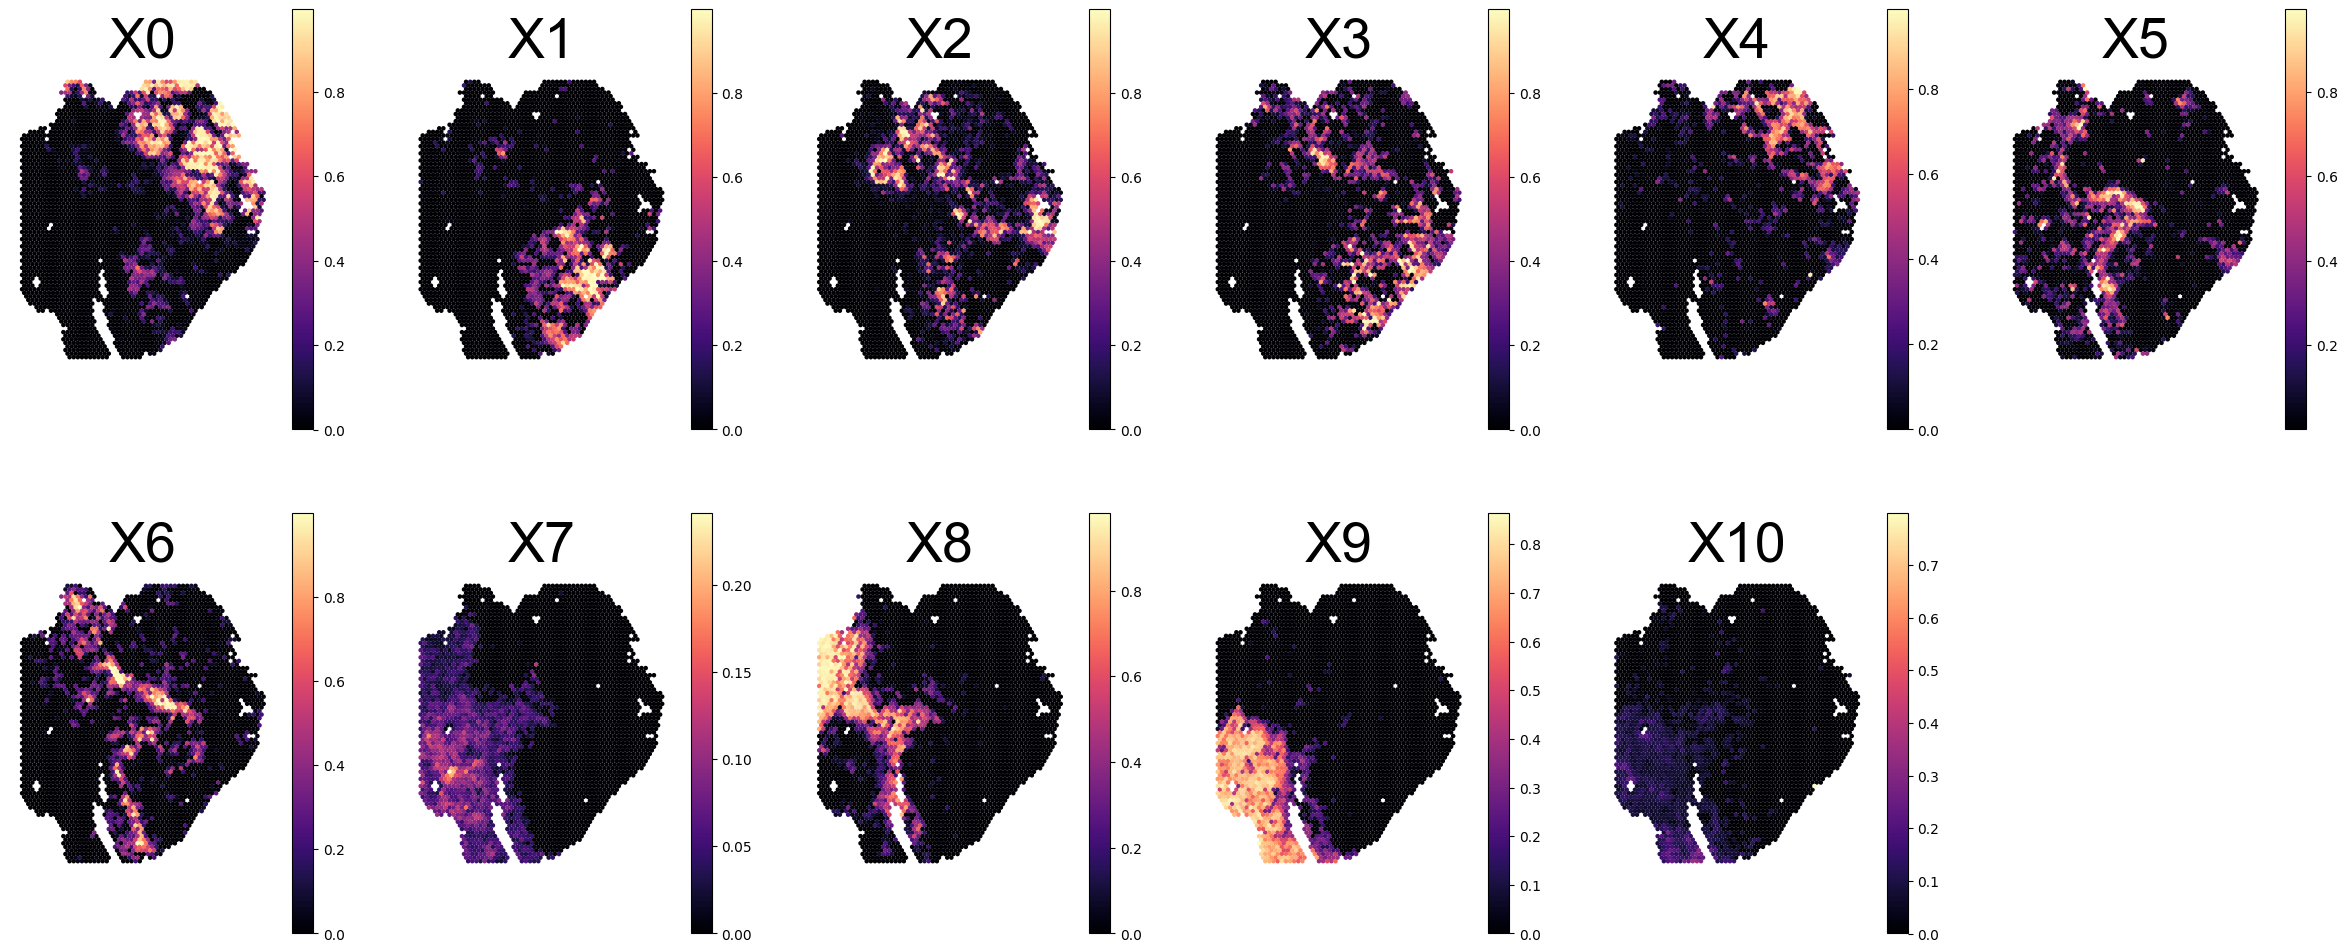

In [10]:
celltype_visualization_visium(pred_p=df_pred_, pos_all=df_pos_, col_num=6)

# 5. Plot of upregulated genes in each deconvolved cell type
### Function input

&nbsp;&nbsp;&nbsp;&nbsp;**df_data**: (dataframe), shape: (n_spots, (3 + n_genes)). The preprocessed ST data. The first three columns represent spot_id, x-coordinate, and y-coordinate, respectively. The remaining columns correspond to different genes.

&nbsp;&nbsp;&nbsp;&nbsp;**df_beta**: (dataframe), shape: (cell_type_number, n_genes). The deconvolved gene expressions of each cell type. 

&nbsp;&nbsp;&nbsp;&nbsp;**topk1**: (int). The number of top genes to plot in each deconvolved cell type.  

&nbsp;&nbsp;&nbsp;&nbsp;**topk2**: (int). The number of top genes to calculate the metagenes in each deconvolved cell type.
### Function output

&nbsp;&nbsp;&nbsp;&nbsp;**df_logFC**: (dataframe), shape: (n_genes, cell_type_number). Gene expression fold changes of each deconvolved cell type relative to the others.

&nbsp;&nbsp;&nbsp;&nbsp;**top_k1_marker_all**: (list), shape: (k1, cell_type_number, ). The top_k1 marker genes in all deconvolved cell types. 

&nbsp;&nbsp;&nbsp;&nbsp;**df_metagene**: (dataframe), shape: (spot, cell_type_number). The metagene expressions of each cell type in each spot. 

In [11]:
from spatialsurf.utils.identify_metagenes import calculate_metagenes, metagene_plot

df_logFC, top_k1_marker_all, df_metagene = calculate_metagenes(df_data=df_pp_data, df_beta=df_beta_, topk1=5, topk2=10)

### Function input

&nbsp;&nbsp;&nbsp;&nbsp;**df_logFC**: (dataframe), shape: (n_genes, cell_type_number). Gene expression fold changes of each deconvolved cell type relative to the others.

&nbsp;&nbsp;&nbsp;&nbsp;**df_beta**: (dataframe), shape: (cell_type_number, n_genes). The deconvolved gene expressions of each cell type. 

&nbsp;&nbsp;&nbsp;&nbsp;**top_k1_marker_all**: (list), shape: (k1 * cell_type_number, ). The top_k1 marker genes in all deconvolved cell types. 

&nbsp;&nbsp;&nbsp;&nbsp;**sel_celltype**: (list). The order of deconvolved cell types for which you want to plot upregulated genes. 

&nbsp;&nbsp;&nbsp;&nbsp;**topk1**: (int). The number of top genes to plot in each deconvolved cell type.

D:\Anaconda\envs\SURF_test\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


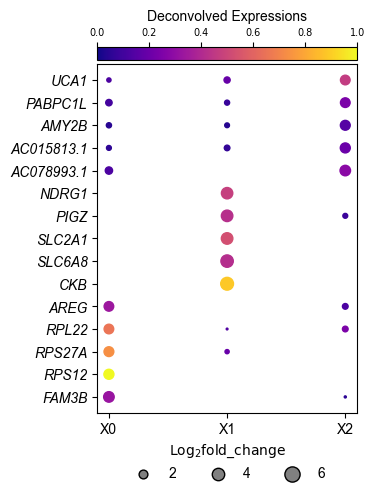

In [12]:
sel_celltype = [0, 1, 2]
metagene_plot(df_logFC=df_logFC, df_beta=df_beta_, top_k1_marker_all=top_k1_marker_all, sel_celltype=sel_celltype, topk1=5)

# 6. Visualization of metagenes in each deconvolved cell type

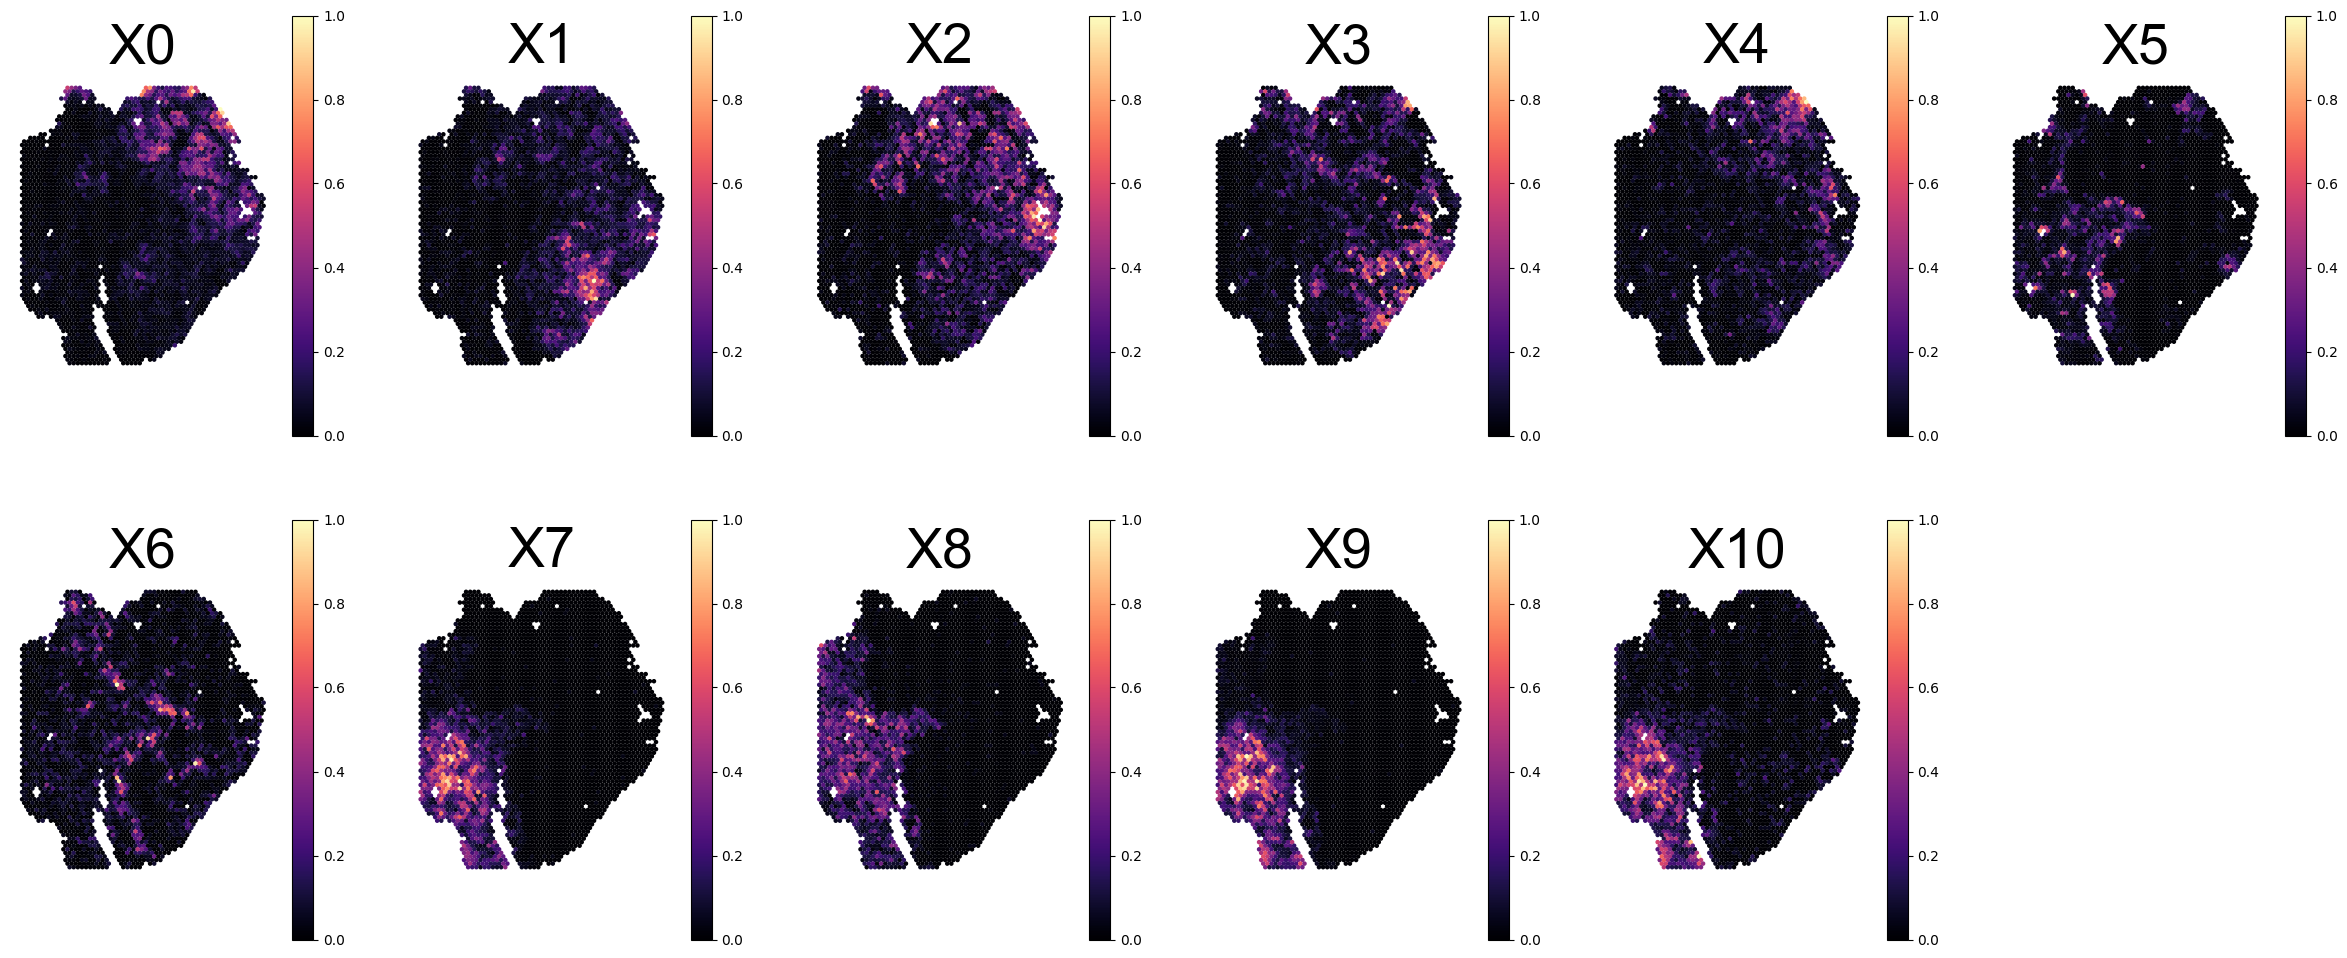

In [13]:
celltype_visualization_visium(df_metagene, df_pos_, col_num=6)

# 7. Gene set enrichment analysis

In [14]:
from spatialsurf.utils.gene_set_enrichment_analysis import run_gsea_with_processed_data, create_gsea_plots_with_r

cell_type_index = [1] 
other_index = [0]

cell_type_mean = df_beta_.iloc[cell_type_index].mean()  
other_mean = df_beta_.iloc[other_index].mean()

logFC = np.log2(cell_type_mean / other_mean)

df = pd.DataFrame({
    'SYMBOL': df_beta_.columns,
    'logFC': logFC
})

df_sorted = df.sort_values('logFC', ascending=False).reset_index(drop=True)

### Function input

&nbsp;&nbsp;&nbsp;&nbsp;**df_sorted**: (dataframe), shape: (n_genes, 2). The sorted logFC values of the differential expression analysis.  

&nbsp;&nbsp;&nbsp;&nbsp;**species**: (str). The source species of the tissue, such as‘Homo sapiens’, ‘Mus musculus’, etc.  

&nbsp;&nbsp;&nbsp;&nbsp;**category**: (str). MSigDB collection abbreviation, such as 'H', 'C1', etc. 

&nbsp;&nbsp;&nbsp;&nbsp;**subcategory**: (str). MSigDB sub-collection abbreviation, such as 'CGP', 'BP', etc.  

&nbsp;&nbsp;&nbsp;&nbsp;(For additional features of GSEA, please refer to https://www.gsea-msigdb.org/gsea/index.jsp)  

### Function output

&nbsp;&nbsp;&nbsp;&nbsp;**results**: (dataframe). GSEA results.  

&nbsp;&nbsp;&nbsp;&nbsp;**gsea_result**: An R object returned by GSEA analysis.  

### Citation
1. Subramanian A, Tamayo P, Mootha V K, et al. Gene set enrichment analysis: a knowledge-based approach for interpreting genome-wide expression profiles[J]. Proceedings of the National Academy of Sciences, 2005, 102(43): 15545-15550.  
2. Mootha V K, Lindgren C M, Eriksson K F, et al. PGC-1α-responsive genes involved in oxidative phosphorylation are coordinately downregulated in human diabetes[J]. Nature genetics, 2003, 34(3): 267-273.

In [15]:
results, gsea_result = run_gsea_with_processed_data(df_sorted=df_sorted, species = 'Homo sapiens', category = 'H', subcategory = 'NULL')

R callback write-console: 
  
R callback write-console: clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141
  
R callback write-console: 
Attaching package: 'clusterProfiler'

  
R callback write-console: The following object is masked from 'package:stats':

    filter

  
R callback write-console: preparing geneSet collections...
  
R callback write-console: GSEA analysis...
  
R callback write-console: leading edge analysis...
  
R callback write-console: done...
  
R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: package 'msigdbr' was built under R version 4.3.3 
  
R callback write-console: 2:   
R callb

### Function input
&nbsp;&nbsp;&nbsp;&nbsp;**results**: (dataframe). GSEA results.  

&nbsp;&nbsp;&nbsp;&nbsp;**gsea_result**: An R object returned by GSEA analysis.  

&nbsp;&nbsp;&nbsp;&nbsp;**plot_dir**: (str). The directory to save the results.  

In [16]:
create_gsea_plots_with_r(results, gsea_result, plot_dir='analysis_save/colorectal_liver_metastasis_GSEA')

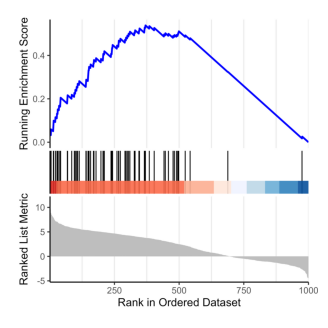

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
img_path = "analysis_save/colorectal_liver_metastasis_GSEA/gsea_enrichment_pathway_plot.jpg"
img = Image.open(img_path)
plt.figure(figsize=(5, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

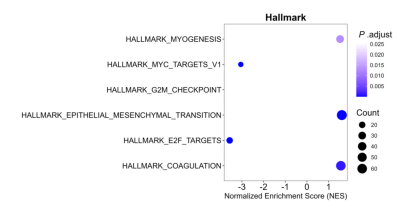

In [18]:
img_path = "analysis_save/colorectal_liver_metastasis_GSEA/gsea_scatter_plot.jpg"
img = Image.open(img_path)
plt.figure(figsize=(5, 4))
plt.imshow(img)
plt.axis('off')  
plt.show()

# 8. Cell-cell communication analysis

In [19]:
from spatialsurf.utils.cell_cell_communication import run_cellchat
df_meta = pd.DataFrame(np.zeros([len(df_pp_data), 2]), columns=['labels', 'samples'], index=df_pp_data.iloc[:, 0].tolist())
df_meta['labels'] = list('X' + df_pred_.idxmax(axis=1).astype(str))
df_meta['samples'] = ['sample1'] * len(df_meta)

### Function input

&nbsp;&nbsp;&nbsp;&nbsp;**count_matrix**: (dataframe), column names: gene names, shape: (n_spots, n_genes). The gene expression of ST data.  

&nbsp;&nbsp;&nbsp;&nbsp;**pos_data**: (dataframe), column names: ‘x’, ‘y’, shape: (n_spots * 2). The position data of ST data.  

&nbsp;&nbsp;&nbsp;&nbsp;**barcodes**:  (list), len: n_spots. The barcodes of ST data.  

&nbsp;&nbsp;&nbsp;&nbsp;**df_meta**: (dataframe), index names: barcodes of spots, column names: ('labels', 'samples'), shape: (n_spots, 2). The dominant cluster of each spot.  

&nbsp;&nbsp;&nbsp;&nbsp;**scale_data_dir**: (str). The directory containing the 'scalefactors_json.json' file.  

&nbsp;&nbsp;&nbsp;&nbsp;**plot_dir**: (str). The directory to save the results.  

&nbsp;&nbsp;&nbsp;&nbsp;**contact_range**: (str).A value giving the interaction range (Unit: microns) to restrict the contact-dependent signaling. (contact.range = 100 for 10X visium data)

&nbsp;&nbsp;&nbsp;&nbsp;**spot_size**: (str). The theoretical spot size of ST data. (spot_size = 65 for 10X visium data)

&nbsp;&nbsp;&nbsp;&nbsp;**species**: (str). The source species of the tissue, such as‘human’, ‘mouse’, etc.   

&nbsp;&nbsp;&nbsp;&nbsp;(For additional features of CellChat, please refer to https://github.com/jinworks/CellChat?tab=readme-ov-file)  
### Citation
1. Jin S, Plikus M V, Nie Q. CellChat for systematic analysis of cell–cell communication from single-cell transcriptomics[J]. Nature protocols, 2025, 20(1): 180-219.  
2. Jin S, Guerrero-Juarez C F, Zhang L, et al. Inference and analysis of cell-cell communication using CellChat[J]. Nature communications, 2021, 12(1): 1088.

In [20]:
run_cellchat(count_matrix=df_expr.copy(), pos_data=df_pos.copy(), barcodes=barcode.copy(), meta=df_meta, scale_data_dir=data_dir, plot_dir='analysis_save/colorectal_liver_metastasis_communication', contact_range=100, spot_size=65, species='human')

R callback write-console: Loading required package: dplyr
  
R callback write-console: 
Attaching package: 'dplyr'

  
R callback write-console: The following object is masked from 'package:nlme':

    collapse

  
R callback write-console: The following objects are masked from 'package:stats':

    filter, lag

  
R callback write-console: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

  
R callback write-console: Loading required package: igraph
  
R callback write-console: 
Attaching package: 'igraph'

  
R callback write-console: The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

  
R callback write-console: The following object is masked from 'package:clusterProfiler':

    simplify

  
R callback write-console: The following objects are masked from 'package:stats':

    decompose, spectrum

  
R callback write-console: The following object is masked from 'package:base':

    union

  



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R callback write-console: Registered S3 method overwritten by 'ggnetwork':
  method         from  
  fortify.igraph ggtree
  
R callback write-console: Loading required package: SeuratObject
  
R callback write-console: Loading required package: sp
  
R callback write-console: 
Attaching package: 'SeuratObject'

  
R callback write-console: The following object is masked from 'package:BiocGenerics':

    intersect

  
R callback write-console: The following object is masked from 'package:base':

    intersect

  
R callback write-console: 
Attaching package: 'Seurat'

  
R callback write-console: The following object is masked from 'package:igraph':

    components

  


[1] "Preprocess data..."
[1] "Create Cellchat data..."
[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial transcriptomics data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  X0, X1, X10, X2, X3, X4, X5, X6, X8, X9 
The number of highly variable ligand-receptor pairs used for signaling inference is 3067 
[1] "Compute communication probabilities..."
truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on spatial transcriptomics data using distances as constraints of the computed communication probability <<< [2025-07-23 23:25:47.614509]"
The input L-R pairs have both secreted signaling and contact-dependent signaling. Run CellChat in a contact-dependent manner for `Cell-Cell Contact` signaling, and in a diffusion manner based on the `interaction.range` for other L-R pairs. 


  |                                                                                                  
  |                                                                                          |   0%  
  |                                                                                                  
  |                                                                                          |   1%  
  |                                                                                                  
  |=                                                                                         |   1%  
  |                                                                                                  
  |=                                                                                         |   2%  
  |                                                                                                  
  |==                                                                             

  |===================                                                                       |  21%  
  |                                                                                                  
  |===================                                                                       |  22%  
  |                                                                                                  
  |====================                                                                      |  22%  
  |                                                                                                  
  |====================                                                                      |  23%  
  |                                                                                                  
  |=====================                                                                     |  23%  
  |                                                                               

  |                                                                                                  
  |======================================                                                    |  43%  
  |                                                                                                  
  |=======================================                                                   |  43%  
  |                                                                                                  
  |=======================================                                                   |  44%  
  |                                                                                                  
  |========================================                                                  |  44%  
  |                                                                                                  
  |========================================                                       

  |=========================================================                                 |  64%  
  |                                                                                                  
  |==========================================================                                |  64%  
  |                                                                                                  
  |==========================================================                                |  65%  
  |                                                                                                  
  |===========================================================                               |  65%  
  |                                                                                                  
  |===========================================================                               |  66%  
  |                                                                               

  |                                                                                                  
  |=============================================================================             |  85%  
  |                                                                                                  
  |=============================================================================             |  86%  
  |                                                                                                  
  |==============================================================================            |  86%  
  |                                                                                                  
  |==============================================================================            |  87%  
  |                                                                                                  
  |===============================================================================

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2025-07-23 23:50:39.776048]"
The cell-cell communication related with the following cell groups are excluded due to the few number of cells:  X10 ! 	0.0% interactions are removed!
[1] "Plot..."


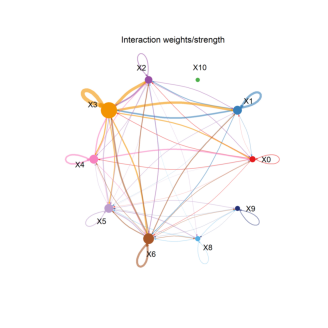

In [21]:
img_path = "analysis_save/colorectal_liver_metastasis_communication/interaction_circle.jpg"
img = Image.open(img_path)
plt.figure(figsize=(5, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

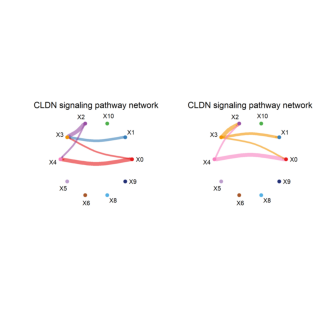

In [22]:
img_path = "analysis_save/colorectal_liver_metastasis_communication/CLDN_interaction_circle.jpg"
img = Image.open(img_path)
plt.figure(figsize=(5, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

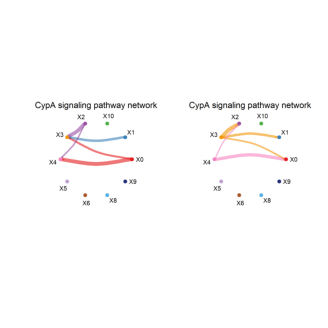

In [23]:
img_path = "analysis_save/colorectal_liver_metastasis_communication/CypA_interaction_circle.jpg"
img = Image.open(img_path)
plt.figure(figsize=(5, 4))
plt.imshow(img)
plt.axis('off')
plt.show()